In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Heatmap Example

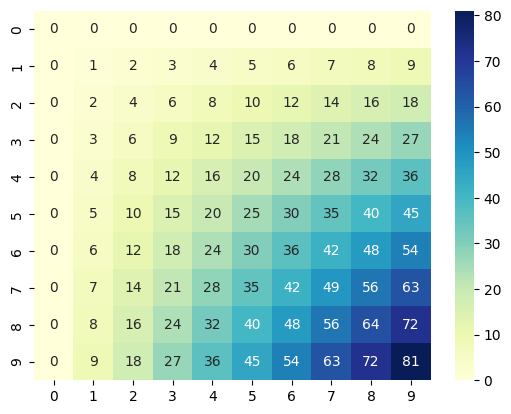

In [2]:
def generate_heatmap_data():
    # Generate a 10x10 matrix of random numbers
    data = [[i * j for j in range(10)] for i in range(10)]
    return data

def plot_heatmap(data):
    # Create a heatmap using seaborn
    sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu")

# Generate the data
data = generate_heatmap_data()

# Plot the heatmap
heatmap = plot_heatmap(data)


In [3]:
from env import TwoRooms, FourRooms

def state_to_coords(env, state, dim):
    """
    Convert a state number to (x, y) coordinates.

    Parameters:
    state_num (int): The state number
    has_wall (bool): Whether there's a wall

    Returns:
    tuple: (row, col) coordinates
    """
    # Convert state number to coordinates
    row = state // dim
    col = state % dim

    if isinstance(env, TwoRooms):
        if state in [
            6,  7,  8,  9, 10, 11,
            18, 19, 20, 21, 22, 23,
            30, 31, 32, 33, 34, 35,
            42, 43, 44, 45, 46, 47,
            54, 55, 56, 57, 58, 59,
            66, 67,  68, 69, 70, 71
        ]:
            col += 1
    elif isinstance(env, FourRooms):
        if state in [
            5,  6,  7,  8,  9,
            15, 16, 17, 18, 19,
            25, 26, 27, 28, 29,
            35, 36, 37, 38, 39,
            45, 46, 47, 48, 49,
            55, 56, 57, 58, 59,
            65, 66, 67, 68, 69,
            75, 76, 77, 78, 79,
            85, 86, 87, 88, 89,
            95, 96, 97, 98, 99
            ]:
            col += 1
        if state in [
            50, 51, 52, 53, 54,
            60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
            70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
            80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
            90, 91, 92, 93, 94, 95, 96, 97, 98, 99
        ]:
            row += 1

    return row, col


def plot_heatmap_from_state_scores(env, state_scores: dict):
    """
    Plot a heatmap of state scores (different metrics) for a given environment.
    """

    # Get the size of the environment
    size = env.size
    wall_col = size[0] // 2
    rows, cols = size

    if isinstance(env, TwoRooms):
        dim = 12
        cols += 1
    elif isinstance(env, FourRooms):
        dim = 10
        cols += 1
        rows += 1

    # Initialize the data grid
    data = np.zeros((rows, cols))

    # Walls
    data[:, wall_col] = -1.
    if isinstance(env, FourRooms):
        data[5, :5] = -1.
        data[6, 6:] = -1.

    # Hallways
    data[2, wall_col] = 0.0
    if isinstance(env, FourRooms):
        data[5, 1] = 0.0
        data[6, 8] = 0.0
        data[9, wall_col] = 0.0

    for state, score in state_scores.items():

        if isinstance(env, TwoRooms) and state == 68:
            row, col = 2, 6
        elif isinstance(env, FourRooms) and state == 75:
            row, col = 5, 1
        elif isinstance(env, FourRooms) and state == 100:
            row, col = 2, 5
        elif isinstance(env, FourRooms) and state == 101:
            row, col = 6, 8
        elif isinstance(env, FourRooms) and state == 102:
            row, col = 9, 5
        else:
            row, col = state_to_coords(env, state, dim)
        data[row, col] = score

    sns.heatmap(data)


def plot_heatmap_from_state_scores_openroom(env, state_scores: dict):
    """
    Plot a heatmap of state scores (different metrics) for a given OpenRoom environment.
    """

    fig, ax = plt.subplots(figsize=(10, 10))

    # Get the size of the environment
    size = env.size
    rows, cols = size

    # Initialize the data grid
    data = np.zeros((rows, cols))

    for state, score in state_scores.items():
        row, col = state_to_coords(env, state, 10)
        data[row, col] = score

    sns.heatmap(data, cmap="YlGnBu")

    return fig, ax

# Sample Trajectories

In [4]:
from agent import SMDPQLearning
from env import FourRooms, TwoRooms, OpenRoom, get_primitive_actions_as_options
from trajectory_sampler import sample


In [5]:
# Start states
openroom_default_s0 = [0]

tworooms_default_s0 = [24]

tworooms_left_room = [
    0, 1, 2, 3, 4, 5,
    12, 13, 14, 15, 16, 17,
    24, 25, 26, 27, 28, 29,
    36, 37, 38, 39, 40, 41,
    48, 49, 50, 51, 52, 53,
    60, 61, 62, 63, 64, 65,
]

fourrooms_default_s0 = [30]

fourrooms_first_room = [
    0, 1, 2, 3, 4,
    10, 11, 12, 13, 14,
    20, 21, 22, 23, 24,
    30, 31, 32, 33, 34,
    40, 41, 42, 43, 44,
]


# Create the environment
openroom = OpenRoom(
    start_states=[0],
    goal_states=[99],
    negative_states_config="none"
)

tworooms = TwoRooms(
    start_states=tworooms_default_s0,
    goal_states=[68],
    negative_states_config="none"
)

fourrooms = FourRooms(
    start_states=fourrooms_first_room,
    goal_states=[75],
    negative_states_config="none"
)

env = openroom

# Set up the agent with primitive options (actions)
primitive_options = get_primitive_actions_as_options(env)

agent = SMDPQLearning(
    env,
    primitive_options,
    learning_rate=0.1,
    discount_factor=0.99,
    exploration_rate=0.1,
    min_exploration_rate=0.1,
    exploration_decay=1,
    log=False
)

# Sample trajectories
print("Sampling trajectories...")
n_samples = 20
trajectories, results, steps, _ = sample(env, agent, n_samples)


Sampling trajectories...


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:01<00:00, 16.68it/s]


In [6]:
all(results)

True

# Heatmaps

## Every visit X First visit

(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

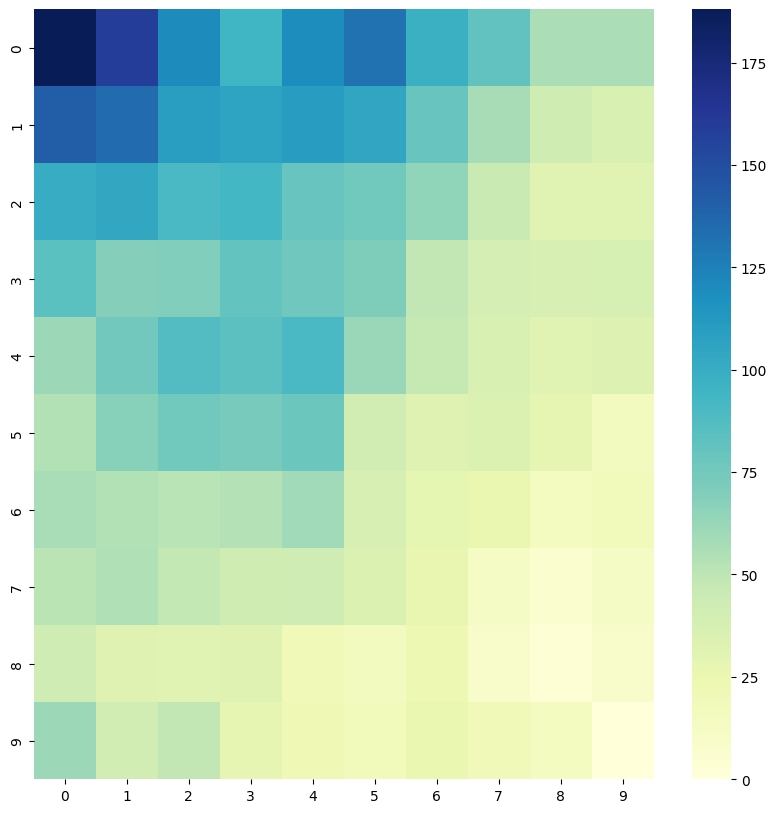

In [7]:
every_visit_scores = {s: 0.0 for s in range(env.observation_space.n)}
for t in trajectories:
    for s in t:
        if s == env.goal_transition_state:
            continue
        every_visit_scores[s] += 1.0

# plot_heatmap_from_state_scores(env, every_visit_scores)
plot_heatmap_from_state_scores_openroom(env, every_visit_scores)


(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

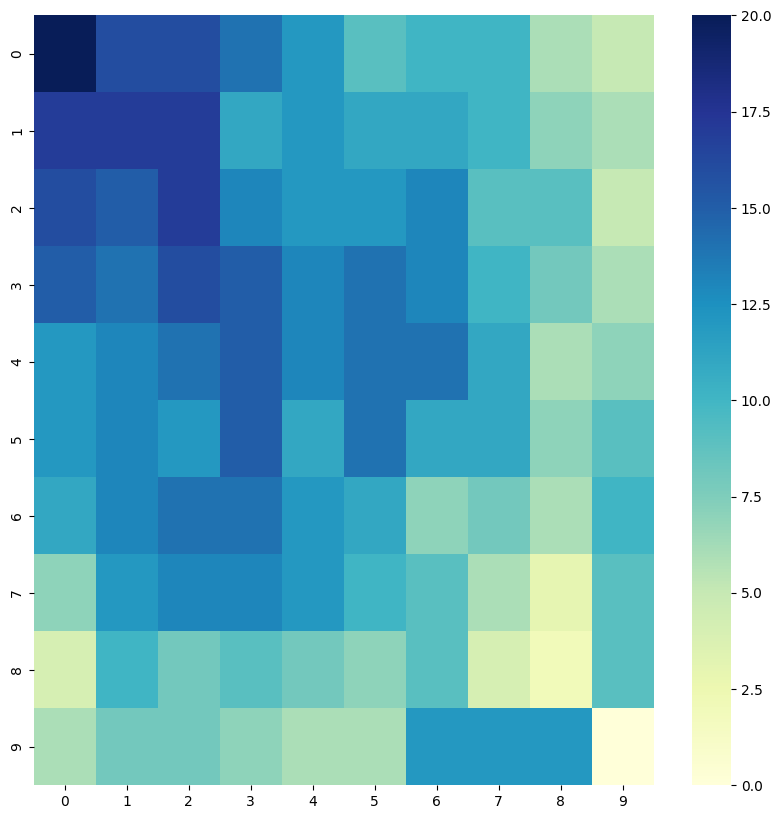

In [8]:
first_visit_scores = {s: 0.0 for s in range(env.observation_space.n)}
for t in trajectories:
    visited = set()
    for s in t:
        if s == env.goal_transition_state or s in visited:
            continue
        first_visit_scores[s] += 1.0
        visited.add(s)

# plot_heatmap_from_state_scores(env, first_visit_scores)
plot_heatmap_from_state_scores_openroom(env, first_visit_scores)


## Empowerment

In [9]:
from empowerment import calculate_empowerment_exact, __transition_matrix

In [10]:
T = __transition_matrix(env)
emp_scores_3 = {}
for s in range(env.observation_space.n):
    emp_scores_3[s] = calculate_empowerment_exact(T, s, 3, 4)
emp_scores_3[0]

emp_scores_11 = {}
for s in range(env.observation_space.n):
    emp_scores_11[s] = calculate_empowerment_exact(T, s, 9, 4)
emp_scores_11[0]

np.float64(5.78135971352466)

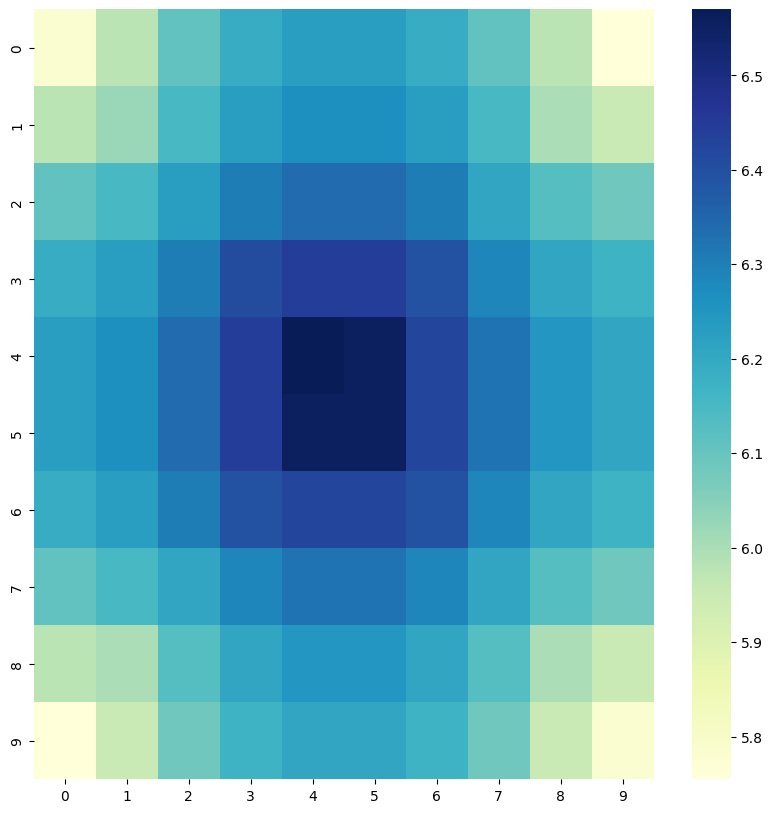

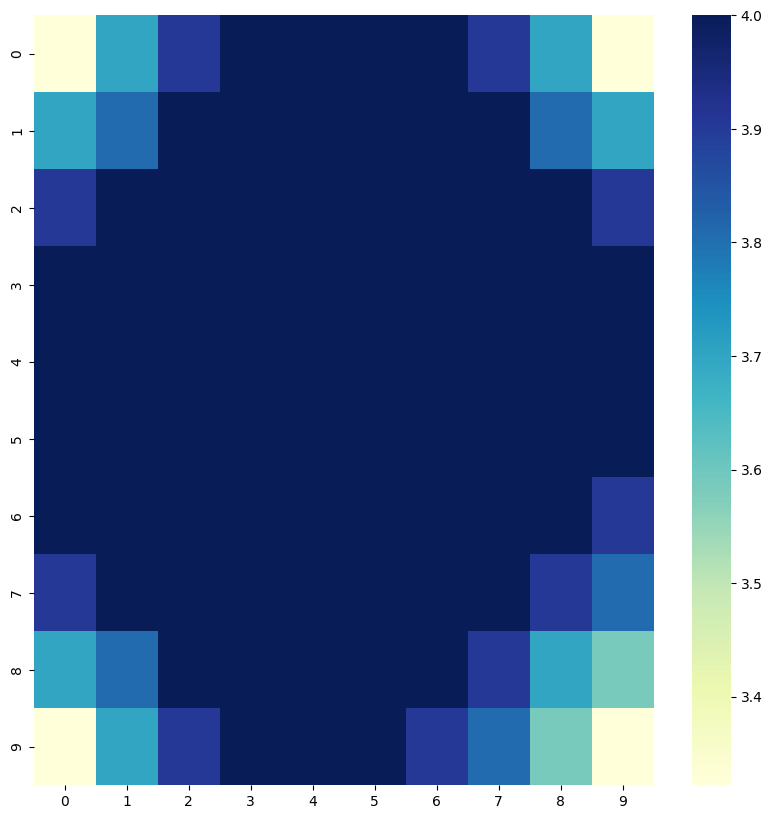

In [11]:
fig1, ax1 = plot_heatmap_from_state_scores_openroom(env, emp_scores_11)
fig2, ax2 = plot_heatmap_from_state_scores_openroom(env, emp_scores_3)

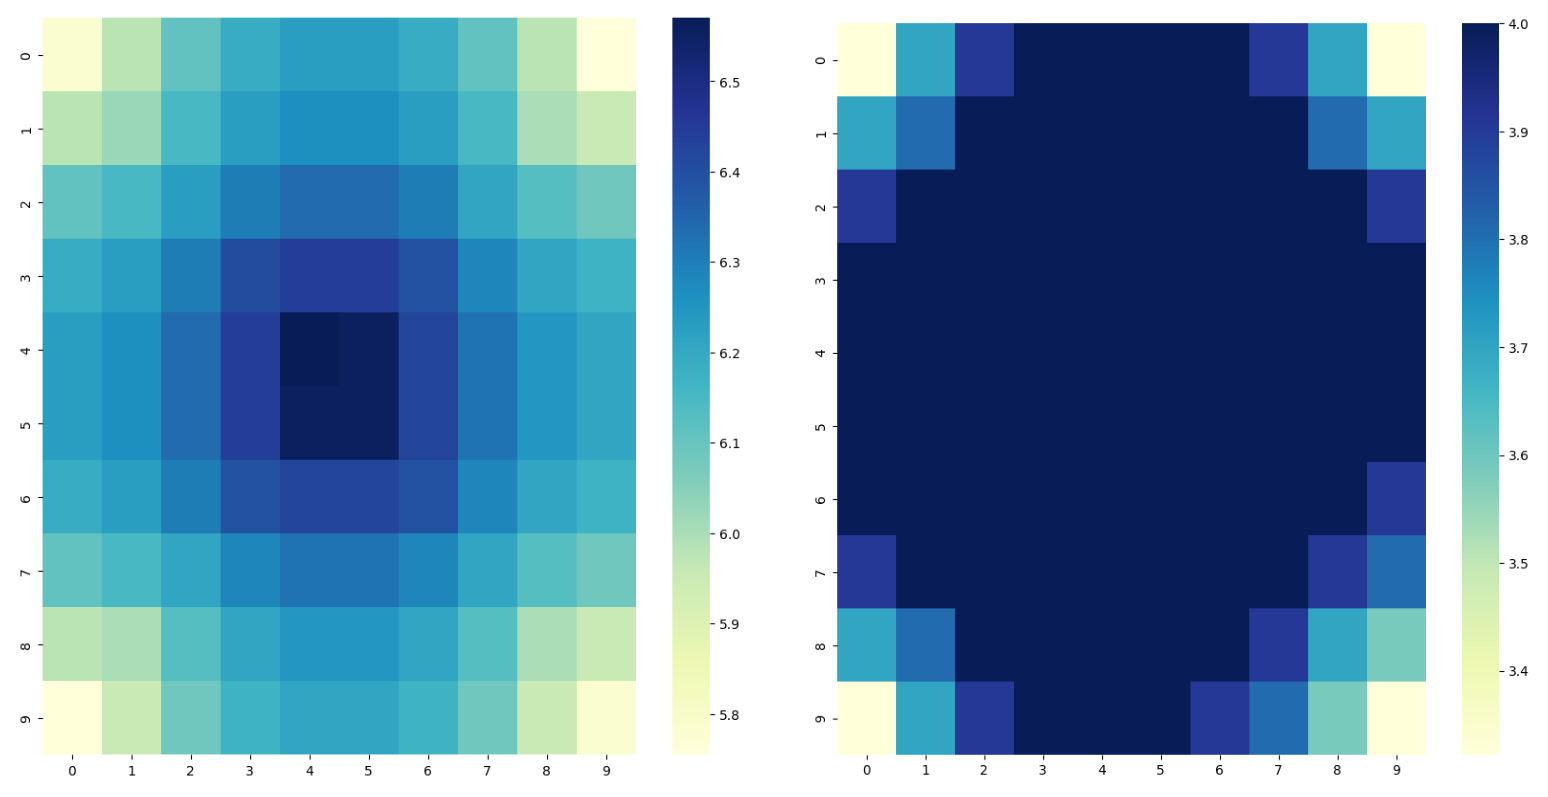

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))

# Bottom left
plt.subplot(2, 2, 3)
plt.imshow(fig1.canvas.buffer_rgba())
plt.axis('off')

# Bottom right
plt.subplot(2, 2, 4)
plt.imshow(fig2.canvas.buffer_rgba())
plt.axis('off')

plt.tight_layout()
plt.savefig('../imgs/emp_openworld.pdf', bbox_inches='tight')
plt.show()